#### Mount Google Drive and Copy Project Directories

Set `COLAB` to True in the following cell if you wish to run in Google Colab.

In [ ]:
# Set to True is working in Google Colab. Make sure you are running on GPU.
COLAB = False

This cell mounts Google Drive in Colab and copies 'toolbox' and 'data' directories from the project's Google Drive location to the Colab environment if they don't already exist.

In [ ]:
if COLAB == True:
    from google.colab import drive
    import shutil
    import os

    drive.mount('/content/drive')

    if os.path.exists('/content/toolbox') == False:
        shutil.copytree('/content/drive/MyDrive/CS502_project/toolbox', '/content/toolbox')
    if os.path.exists('/content/data') == False:
        shutil.copytree('/content/drive/MyDrive/CS502_project/data', '/content/data')
    if os.path.exists('/content/unet++.pt') == False:
        shutil.copy('/content/drive/MyDrive/CS502_project/unet++.pt', '/content/unet++.pt')
    if os.path.exists('/content/resnet50.pt') == False:
        shutil.copy('/content/drive/MyDrive/CS502_project/resnet50.pt', '/content/resnet50.pt')

# **Fusion of U-Net++ and ResNet50 Models for Melanoma Diagnosis from Dermoscopic Images**

Team 45, Kilian Zell 287515

### PROBLEM STATEMENT

Skin cancer is the most prevalent type of cancer, and while melanoma constitutes only around 1% of them, it is responsible for the majority of skin cancer-related death. Currently, melanoma diagnoses rely primarily on the visual examination of skin lesions by dermatologists. Unfortunately, this kind of diagnosis is prone to subjectivity and errors. This significantly impact patients' well-being, as an early-stage misdiagnosis can substantially diminish overall chances of survival.

### PROPOSED SOLUTION

In this context, deep learning has the potential to significantly enhance the consistency and accuracy of diagnosis while remaining entirely non-invasive. In this work, a model specifically designed to classify skin lesions as 'melanoma' or 'non-melanoma' is proposed. In unsegmented dermoscopic images, the borders of a lesion and skin texture can lead to unwanted feature extraction, affecting the overall performance of classification. To overcome this challenge, the proposed model first extract the Region of Interest (ROI) form the input image using a U-Net++ inspired model so that only relevant features are considered for diagnosis. The resulting segmented region is then fed into a pre-trained ResNet50 calibrated for binary classification to obtain the final prediction.

### WORKFLOW

This notebook is structured into three main parts:

**Part 1: Lesion Segmentation.** In this initial phase of the project, the focus is on implementing advanced image processing and machine learning techniques to achieve precise and dependable lesion segmentation from dermoscopic images. The evaluation will be based on several performance metrics, including the Dice coefficient and pixel-level accuracy.


**Part 2: Lesion Classification.** Building upon the 'region of interest' extraction approach developed in the previous part, this part aims to predict lesion disease states, categorizing them as either 'melanoma' or 'non-melanoma'. The model performance evaluation will involve key metrics such as accuracy, specificity, sensitivity, precision, and F1-score.

*---Please be aware that the following section has been implemented successfully but has not undergone thorough testing. Therefore, you may choose to disregard this section entirely.---*

**Part 3: Metadata Integration.** In this section, the aim is to extend the classification efforts by incorporating additional available patient metadata (age, lesion location, and sex). The model performance evaluation will involve key metrics such as accuracy, specificity, sensitivity, precision, and F1-score.

# Environment Setup and Device Configuration


### Package Installation

The provided command utilizes pip3 to install essential Python libraries for this project. These libraries include NumPy for numerical operations, Pillow for image processing, Matplotlib for data visualization, PyTorch and Torchvision for deep learning tasks, OpenCV-Python for computer vision, and additional utilities like SciPy and scikit-image. Ensure that you have the necessary Python environment set up before executing this command to ensure a seamless installation of the required packages.

In [ ]:
# Uncomment to install the requirements. DO NOT un-comment if working in Colab.
#!pip3 install numpy==1.24.4 Pillow==10.1.0 matplotlib==3.7.4 torch==2.1.1 torchvision==0.16.1 opencv-python==4.8.1.78 scipy==1.10.1 scikit-image==0.21.0 pandas==2.0.3

### Library Import

This code cell starts by importing essential libraries such as NumPy, operating system utilities, and PyTorch modules. Additionally, it incorporates a custom `toolbox` with modules for utility functions, dataset handling, model architectures, training procedures, and plotting tools.

In [ ]:
# Import necessary libraries
import numpy as np
import os
import itertools
import random

# Import PyTorch modules
import torch
from torch.utils.data import WeightedRandomSampler

# Import custom toolbox modules
from toolbox import utils, dataset, models, training, plots

### Device Configuration and GPU Monitoring

This code cell checks for the availability of a GPU and sets the device accordingly, prioritizing GPU if available; otherwise, it defaults to CPU. It also provides information on GPU memory usage.

Please note that this code may need adjustments based on your computing environment. Ensure that the necessary libraries and configurations are set up, and modify the code accordingly to match your specific system.

- The device variable is set to "mps" if Torch MPS (Multi-Process Service) is available, indicating GPU usage; otherwise, it is set to "cpu."
- An environment variable (`PYTORCH_MPS_HIGH_WATERMARK_RATIO`) is set to "0.0" to manage memory usage.
- The value of the environment variable is then checked and displayed.
- GPU memory allocation and caching information are printed to provide insights into GPU memory usage.

Review and adapt this code to suit the specifications of your computing system.

For Google Colab, simply de-comment the corresponding code and delete the rest of the cell.

In [ ]:
# Set device as CUDA to use GPU in Colab
if COLAB == True:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"| Using device                 | {device}")

else:
    # Check and set device (GPU if available, else CPU)
    device = "mps" if torch.backends.mps.is_available() else "cpu" 

    # Set the environment variable
    os.environ["PYTORCH_MPS_HIGH_WATERMARK_RATIO"] = "0.0"

    # Check the value of the environment variable
    mps_high_watermark_ratio = os.environ.get("PYTORCH_MPS_HIGH_WATERMARK_RATIO", "Not set")

    # Check GPU memory usage
    gpu_memory_allocated = torch.cuda.memory_allocated() / (1024 ** 3)  # in GB
    gpu_memory_cached = torch.cuda.memory_cached() / (1024 ** 3)  # in GB

    print("+" + "-" * 30 + "+")
    print(f"| Using device                 | {device:<20}")
    print(f"| WATERMARK_RATIO              | {mps_high_watermark_ratio:<20}")
    print(f"| GPU memory allocated         | {gpu_memory_allocated} GB{' ' * (20 - len(str(gpu_memory_allocated)))}")
    print(f"| GPU memory cached            | {gpu_memory_cached} GB{' ' * (20 - len(str(gpu_memory_cached)))}")
    print("+" + "-" * 30 + "+")

+------------------------------+
| Using device                 | mps                 
| WATERMARK_RATIO              | 0.0                 
| GPU memory allocated         | 0.0 GB                 
| GPU memory cached            | 0.0 GB                 
+------------------------------+


/Users/kilianzell/pytorch-test/env/lib/python3.8/site-packages/torch/cuda/memory.py:444: FutureWarning: torch.cuda.memory_cached has been renamed to torch.cuda.memory_reserved
  warnings.warn(


# PART 1: U-Net-based Skin Lesions Segmentation

In this initial phase of the project, the focus is on implementing advanced image processing and machine learning techniques to achieve precise and dependable lesion segmentation from dermoscopic images. The evaluation will be based on several performance metrics, including the Dice coefficient and pixel-level accuracy.

## 1. Dataset and Dataloader

The following datasets are compatible with this part of the project:

- [ISIC 2016](https://challenge.isic-archive.com/data/): Train (900 samples) and test (380 samples) datasets consisting of dermoscopic lesion images in JPEG format along with their corresponding binary mask images in PNG format.
- [ISIC 2017](https://challenge.isic-archive.com/data/): Train (2000 samples) and test (600 samples) datasets consisting of dermoscopic lesion images in JPEG format along with their corresponding binary mask images in PNG format.
- [ISIC 2018](https://challenge.isic-archive.com/data/): Train (2594 samples) and test (1000 samples) datasets consisting of dermoscopic lesion images in JPEG format along with their corresponding binary mask images in PNG format.
- [HAM10000](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T):  Compiled dataset consisting of 10015 dermatoscopic images in JPEG format along with their corresponding binary mask images in PNG format.

Please note that for the purpose of this work, only HAM10000 was considered for training and testing the final models.

### Dataset Preparation and Formatting

This code cell defines the path for the dataset and specifies the dataset to be used. It also includes commands to unzip and format the dataset, with relevant comments guiding adjustments based on the user's folder structure.

Please modify the `DATASET_PATH` and `DATASET_USED` variables to match your specific folder structure. Uncomment the lines related to dataset unzipping and formatting if these operations are required.

- `DATASET_PATH`: Adjust this variable to the root path where your dataset is stored.
- `DATASET_USED`: Specify the name of the dataset to be utilized.
- `TEST_FOLDER`: Should be set to 'True' if the test dataset is provided in the data folder.
- `SPLIT_RATIO`: If `TEST_FOLDER` is set to 'False', will split the dataset randomly in train and test dataset given the split ratio. 
- `DATA_PATH`: Complete path to the dataset is created using `os.path.join`.

Ensure that the dataset is organized according to your project's specifications before running this code.

In [60]:
# Reload the plot module using importlib
import importlib
importlib.reload(utils)

# Define the path for the dataset and specify the dataset to be used
DATASET_PATH = 'data' # Modify to match your folder structure. For Colab: '/content/data'.
DATASET_USED = 'HAM10000' # Change if you wish to work with a different dataset.
TEST_FOLDER = False # 'True' if the test dataset is already provided in the datafolder ('False' for HAM10000)
SPLIT_RATIO = 0.2 # Test/Train split ratio

# Create the complete path to the dataset
DATA_PATH = os.path.join(DATASET_PATH, DATASET_USED)

# Delete data foders if they already exist
utils.delete_folder(DATA_PATH)

# Uncomment the following line to unzip the dataset if needed
utils.unzip_data(DATASET_PATH, DATASET_USED)

if TEST_FOLDER == True:
    print('The test sample is already provided and therefore the SPLIT_RATIO is not taken into account.')
    # Format the dataset for processing
    utils.format_dataset(DATA_PATH, task='segmentation')

elif TEST_FOLDER == False:
    # Split in train and test dataset according to the SPLIT_RATIO
    utils.split_folders(DATA_PATH, p_test=SPLIT_RATIO) 

    # Format the dataset for processing
    utils.format_dataset(DATA_PATH, task='segmentation')

The file data/HAM10000.zip is properly loaded.
Dataset successfully uploaded to the current directory.
Execution time: 6.67723274230957 seconds


### Dataset Loading and DataLoader Creation

In this code segment, the batch size for data loading is set. Subsequently, training and testing datasets are created using the `LesionDataset` class, specifying the dataset path (`DATA_PATH`), data type ('train' or 'test'), and the segmentation task.

Additionally, DataLoader instances are created to facilitate efficient batch loading during both training and testing phases.

- `BATCH_SIZE`: Specifies the number of samples per batch during data loading. Adjust this value based on your resource availability and model requirements.
- `lesion_dataset_train` and `lesion_dataset_test`: Instances of the `LesionDataset` class are created for training and testing, respectively.
- `trainloader` and `testloader`: DataLoader instances are generated for efficient batch loading during model training and evaluation.

In [61]:
# Reload the dataset module using importlib
import importlib
importlib.reload(dataset)

# Set the batch size for data loading
BATCH_SIZE = 32

# Create training and testing datasets using the LesionDataset class
lesion_dataset_train = dataset.LesionDataset(DATA_PATH, TYPE='train', task='segmentation')
lesion_dataset_test = dataset.LesionDataset(DATA_PATH, TYPE='test', task='segmentation')

# Create DataLoader instances for efficient batch loading during training and testing
trainloader = torch.utils.data.DataLoader(lesion_dataset_train, BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(lesion_dataset_test, BATCH_SIZE, shuffle=True)

# Display the sizes of the original, training, and test datasets
print(f'Orginal dataset:  {len(lesion_dataset_train) + len(lesion_dataset_test)}')
print(f'Training dataset:  {len(lesion_dataset_train)}')
print(f'Test dataset:      {len(lesion_dataset_test)}')

Orginal dataset:  10015
Training dataset:  8012
Test dataset:      2003


### Data Transformation

The following transformations are applied to the training set:
- `TF.hflip()`: Random horizontal flipping with a probability of 50%
- `TF.vflip()`: Random vertical flipping with a probability of 50%
- `T.RandomRotation()`: Random rotation up to 45 degrees with a probability of 50%
- `T.RandomAffine()`: Random zoom with a maximum of 120% with a probability of 50%
- `add_hair()`: Add artificial hair with a probability of 75%
- `cutmix()`: Apply CutMix data augmentation with a probability of 25%
- `mosaic()`: Combine images in mosaic with a probability of 25%

Note that proper resizing (256x256) is also performed to match the different model needs.

The following code snippet randomly selects an index within the training dataset (`lesion_dataset_train`) and uses the plot_data function from the plot module to visualize the corresponding data.

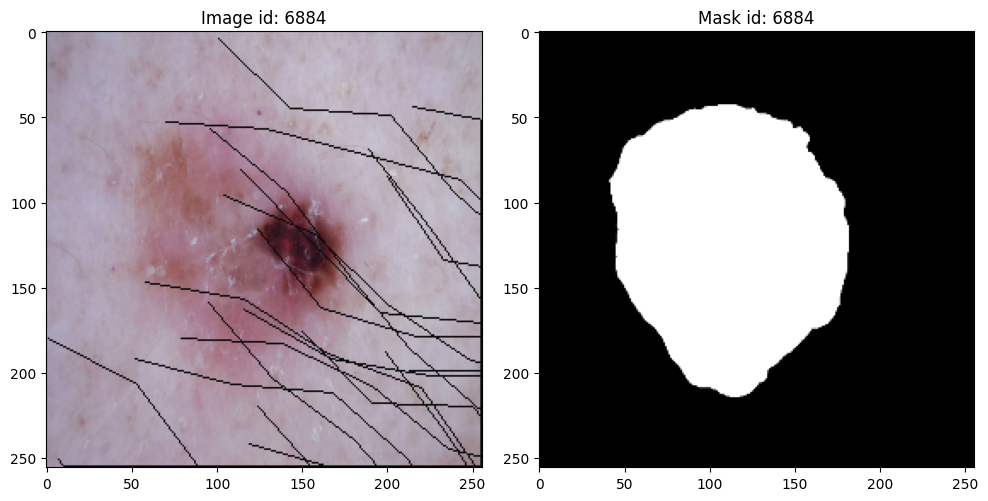

In [76]:
# Reload the plot module using importlib
import importlib
importlib.reload(plots)

# Generate a random index for visualization within the training dataset
i = random.randint(0, len(lesion_dataset_train) - 1)

# Plot the data using the plot_data function from the plot module
plots.plot_data_PART1(lesion_dataset_train, i)

## 2. Segmentation Model Configuration and Initialization

This code segment defines the chosen model (`MODEL`) and sets the succession of filters (`FILTER`) based on the selected architecture.

The script then chooses and initializes the specified model according to the selected architecture:

- `MODEL`: Represents the chosen model architecture. Modify this variable to select the desired model (e.g., 'random', 'constant', 'simple_cnn', 'unet', or 'unet++').
- `FILTER`: Specifies the succession of filters, determining the model's complexity. Adjust these values based on your specific model requirements (you may also neeed to resize your input images accordingly).

In [63]:
# Reload the model module using importlib
import importlib
importlib.reload(models)

# Define the chosen model and set the filter numbers
MODEL = 'unet++' # Change according to the model you want to train
FILTER = [8, 16, 32, 64, 128] #Set the succession of filters

# Choose and initialize the specified model based on the selected architecture
if MODEL == 'random':
    model = models.RandomGuessModel().to(device)
elif MODEL == 'constant':
    model = models.ConstantModel().to(device)
elif MODEL == 'simple_cnn':
    model = models.SimpleCNN().to(device)
elif MODEL == 'unet':
    model = models.UNet(filter_num=FILTER).to(device)
elif MODEL == 'unet++':
    model = models.UNetPlusPlus(filter_num=FILTER).to(device)
else:
    raise ValueError('Please choose one of the following models: random, constant, simple_cnn, unet, or unet++')

## 3. Model Training

In this script users can specify whether to load a pre-trained model (`LOAD`) and set the model name accordingly.

The Trainer is then initialized with the specified model and device, and based on the `LOAD` condition, either a new model is trained or a pre-trained model is loaded.

- If `LOAD` is set to `False`, the script defines parameters for training, such as the number of epochs (`EPOCHS`), learning rate (`LEARNING_RATE`), weight decay (`WEIGHT_DECAY`), and gradient clipping (`CLIP_GRADIENT`). The model is then trained for the specified number of epochs unless it's the 'random' or 'constant' model. Training and testing losses are recorded.

- If `LOAD` is set to `True`, a pre-trained model with the specified name (`MODEL_NAME`) is loaded using the `trainer.load_model` function.

In either case, informative messages are printed, indicating the completion of the training process or the successful loading of a pre-trained model.

In [64]:
# Reload the training module using importlib
import importlib
importlib.reload(training)

# Specify whether or not to load the pre-trained model
LOAD = False

# Set the model name
MODEL_NAME = f'{MODEL}.pt'

# Initialize the Trainer with the specified model and device
trainer = training.Trainer(model, device, task='segmentation')

if LOAD == False:
    # Set the number of training epochs
    EPOCHS = 40
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 0.
    CLIP_GRADIENT = False

    # Train the model if it's not the random model
    if MODEL != 'random' and MODEL != 'constant':
      # Train the model for the specified number of epochs
      losses_train, losses_test = trainer.train(EPOCHS, trainloader, testloader, model_name=MODEL_NAME, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY, clip_gradient=CLIP_GRADIENT)

    # Display a message indicating the completion of the training process
    print(f'Training finished!')

else:
    # Load a pre-trained model
    trainer.load_model(MODEL_NAME)
    print(f'Pre-trained model {MODEL_NAME} loaded successfuly.')

Starting Training Process
Model saved at unet++.pt
Epoch: 001, Train Loss: 0.0338992, Test Loss: 0.0312980, Time: 203.034 sec/epch
Epoch: 002, Train Loss: 0.0292490, Test Loss: 0.0294313, Time: 205.666 sec/epch
Epoch: 003, Train Loss: 0.0273538, Test Loss: 0.0272919, Time: 203.254 sec/epch
Epoch: 004, Train Loss: 0.0257096, Test Loss: 0.0256361, Time: 205.023 sec/epch
Epoch: 005, Train Loss: 0.0244097, Test Loss: 0.0250946, Time: 206.494 sec/epch
Model saved at unet++.pt
Epoch: 006, Train Loss: 0.0231490, Test Loss: 0.0233628, Time: 204.642 sec/epch
Epoch: 007, Train Loss: 0.0219629, Test Loss: 0.0220623, Time: 204.315 sec/epch
Epoch: 008, Train Loss: 0.0209507, Test Loss: 0.0203828, Time: 206.644 sec/epch
Epoch: 009, Train Loss: 0.0198778, Test Loss: 0.0199248, Time: 203.855 sec/epch
Epoch: 010, Train Loss: 0.0187596, Test Loss: 0.0187515, Time: 204.068 sec/epch
Model saved at unet++.pt
Epoch: 011, Train Loss: 0.0179494, Test Loss: 0.0188445, Time: 206.060 sec/epch
Epoch: 012, Train L

### Loss Visualization

This section checks if the selected model is not a benchmark model or a pre-trined model. 

- If the model is not a benchmark or pre-trained model (`LOAD == False`), the script plots the training and testing loss curves using the `plot_loss` function from the `plots` module.

- For benchmark models ('random' or 'constant') or pre-trained models, a message is printed indicating that loss plots are not available.

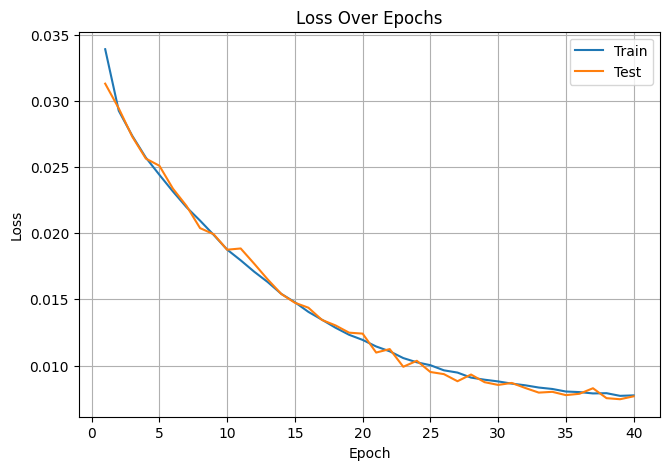

In [65]:
# Reload the plot module using importlib
import importlib
importlib.reload(plots)

# Check if the model is not a benchmark model (neither random nor constant)
if MODEL != 'random' and MODEL != 'constant':
  if LOAD is False:
    # Plot the training and testing loss curves using the plot_loss_unet function
    plots.plot_loss(losses_train, losses_test, save_path=None)
  else:
    # Print a message indicating that loss plots are not available for pre-loaded models
    print('Loss plot not available for pre-loaded models (please see the associated report).')
else:
  # Print a message indicating that loss plots are not available for benchmark models
  print('Loss plot not available for benchmark models.')

## 4. Model Evaluation and Performance Scores

This script checks whether the selected model is not a benchmark model (neither 'random' nor 'constant').

- If the model is not a benchmark, the script proceeds to load the state dictionary from the saved model. Depending on the availability of a GPU, the model is loaded directly if a GPU is present; otherwise, it is loaded onto the CPU using `map_location`.

- Subsequently, the model's performance is evaluated, and scores are obtained using the `get_scores_CLASS` function from the `utils` module. The evaluation involves comparing model predictions on the train and test dataset (`lesion_dataset_train` and `lesion_dataset_test`) against the ground truth labels. The specified threshold (`THRESHOLD`) is used to classify predictions.

In [66]:
# Reload the utils module using importlib
import importlib
importlib.reload(utils)

THRESHOLD = 0.5

# Check if the model is not a benchmark model (neither random nor constant)
if MODEL != 'random' and MODEL != 'constant':
  # Load the state dictionary from the saved model, use map_location to load on the CPU
  model = torch.load(MODEL_NAME, map_location=torch.device('cpu'))

# Evaluate the model's performance and obtain scores using the get_scores function
utils.get_scores_SEG(trainer, lesion_dataset_test, dataset_train=None, threshold=THRESHOLD) # Set 'dataset_train = lesion_dataset_train' to get the training metrics

Metric                         Test           
Pixel-wise Accuracy            0.9522         
Dice Coefficient               0.9135         


### Model Prediction Visualization

This code cell generates a random index for visualization within the testing dataset, retrieves a sample from the dataset and makes a prediction.

- `i`: A random index is generated to select a sample from the testing dataset.
- `sample`: Retrieves the corresponding sample from the testing dataset.
- `image`, `mask`, and `output`: Prediction is made using the trained model with a specified probability threshold.
- `title`: A title is set for visualization.
- The `show_prediction` function from the `plots` module is then used to display the input image, ground truth mask, and model output.

Adjust the index (`i`) and probability threshold as needed, and ensure that the `plots` module is correctly defined before running this code.

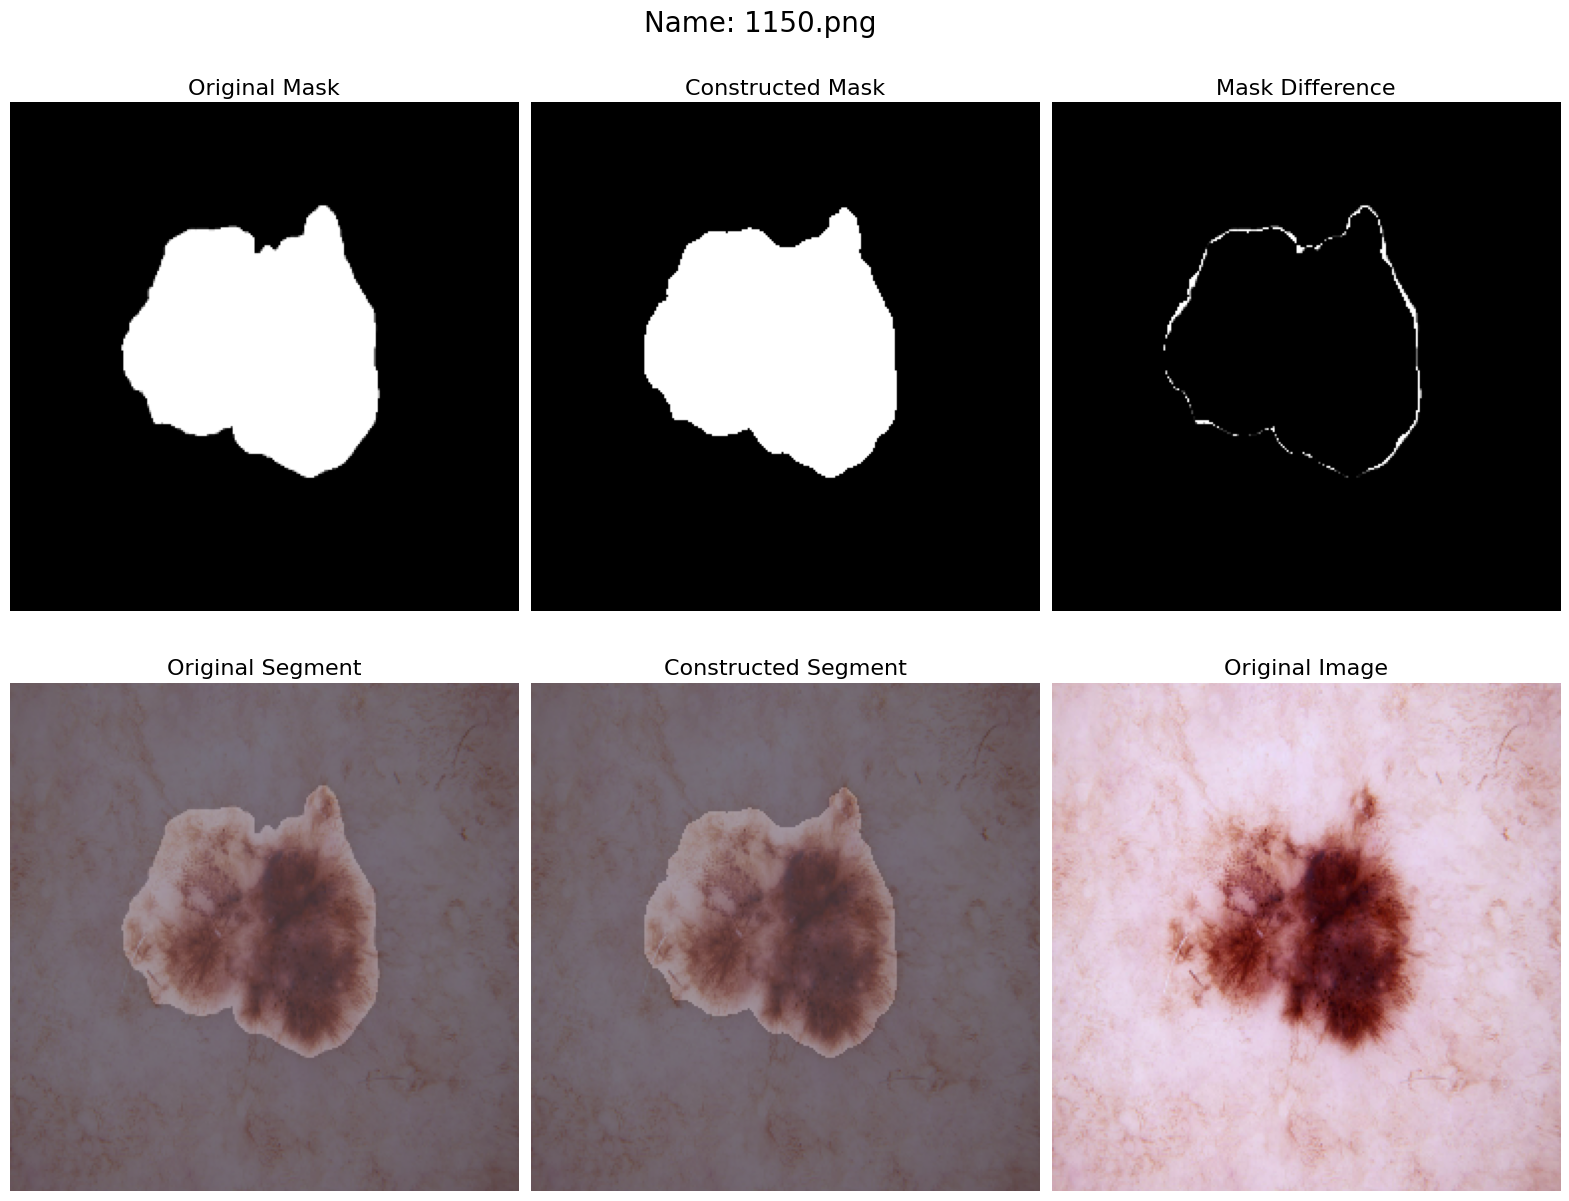

In [161]:
# Reload the utils and training modules using importlib
import importlib
importlib.reload(utils)
importlib.reload(training)

# Generate a random index for visualization within the testing dataset
i = random.randint(0, len(lesion_dataset_test) - 1)

# Retrieve a sample from the testing dataset
sample = lesion_dataset_test[i]

# Make a prediction using the trained model
image, mask, output = trainer.predict(sample, threshold=THRESHOLD)

# Set the title for visualization
title = f'Name: {i}.png'

# Display the input image, ground truth mask, and model output using the show_prediction function
plots.show_prediction(image, mask, output[0], title, save_path=None)

### Output Post-Processing

This code cell applies the `keep_main_region` function. The function is used to remove any isolated positive detection from the final prediction and to remove negative instances in the main positive area.

The `keep_main_region` function is defined in the `dataset` module and performs the following steps:
  - Converts the input PyTorch tensor to a NumPy array.
  - Converts the output to uint8 and a single-channel image.
  - Finds contours in the output and identifies the contour with the largest area.
  - Sets to '1' anything that is inside the largest area.
  - Sets to '0' anything that is outside the largest area.

The resulting `new_output` is then visualized alongside the original mask and initial model output using the `show_post_processing` function from the `plots` module.

/Users/kilianzell/pytorch-test/project/toolbox/plots.py:199: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


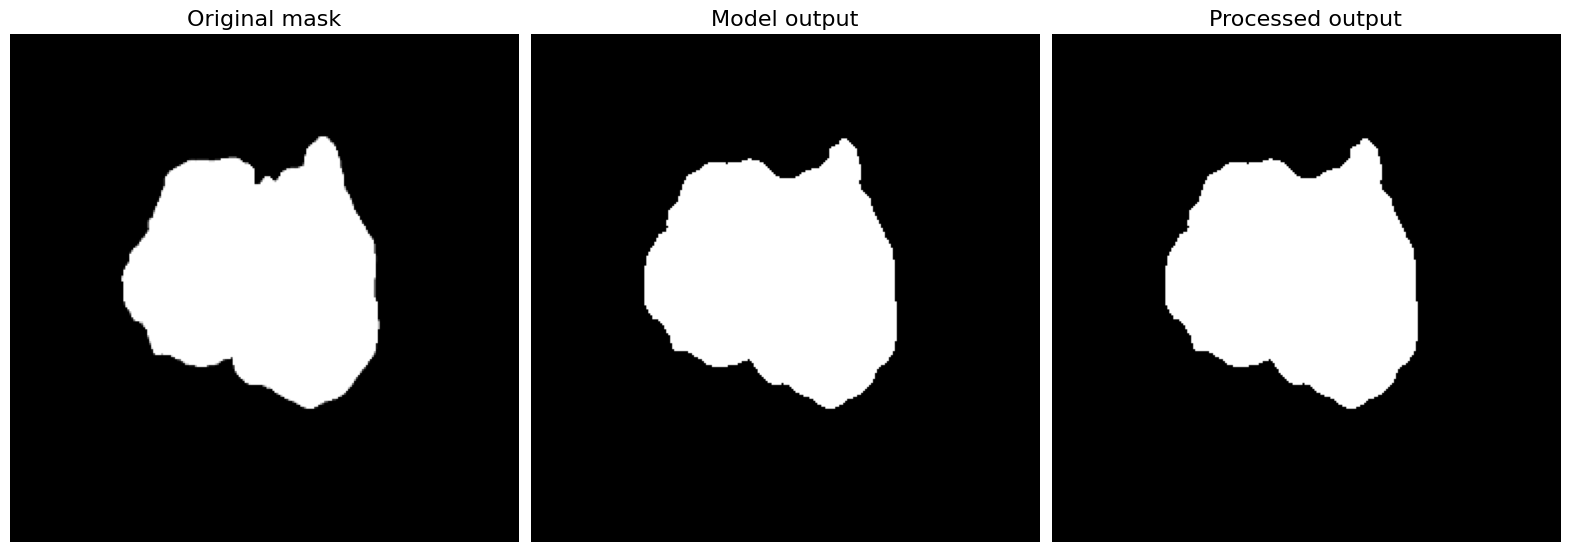

In [162]:
# Reload the utils module using importlib
import importlib
importlib.reload(dataset)

# Apply the keep_main_region function from the reloaded utils module
new_output = dataset.keep_main_region(output[0])

# Visualize the original mask, the initial output, and the new_output
plots.show_post_processing(mask, output[0], new_output)

### Final Model Evaluation and Performance Scores

This code snippet checks whether the selected model is not a benchmark model (neither 'random' nor 'constant').

- If the model is not a benchmark, it proceeds to load the trained model from the saved file (`MODEL_NAME`).
- Subsequently, the model's performance is evaluated, and scores are obtained using the `get_scores_SEG` function from the `utils` module.
- The evaluation involves comparing model predictions on the training and testing dataset (`lesion_dataset_train` and `lesion_dataset_test`) against the ground truth masks. The specified threshold (`THRESHOLD`) is used to classify predictions.
- The `processing` parameter is set to `True` to enable the additional post-processing step described above to be applied to the final prediction.

In [69]:
# Reload the utils module using importlib
import importlib
importlib.reload(utils)

# Check if the model is not a benchmark model (neither random nor constant)
if MODEL != 'random' and MODEL != 'constant':
  # If no GPU is available, use map_location to load on the CPU
  model = torch.load(MODEL_NAME, map_location=torch.device('cpu'))

# Evaluate the model's performance and obtain scores using the get_scores function
utils.get_scores_SEG(trainer, lesion_dataset_test, dataset_train=None, threshold=THRESHOLD, processing=True) # Set 'dataset_train = lesion_dataset_train' to get the training metrics

Metric                         Test           
Pixel-wise Accuracy            0.9531         
Dice Coefficient               0.9145         


# PART 2: Lesion Binary Classification
Building upon the 'region of interest' detection approach developed in the previous part, this part aims to predict lesion disease states, categorizing them as either 'melanoma' or 'non-melanoma'. The model performance evaluation involves key metrics such as accuracy, specificity, sensitivity, precision, and F1-score.

## 1. Dataset and Dataloader

The following datasets are compatible with this part of the project:

- [HAM10000](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T):  Compiled dataset consisting of 10'015 dermatoscopic images in JPEG format along with their corresponding binary mask images in PNG format and entries indicating gold standard malignant status (skin lesion classification in 7 standard categories).
- [ISIC2019](https://challenge.isic-archive.com/data/#2019):  Compiled dataset consisting of 25'331 dermatoscopic images in JPEG format along with entries indicating gold standard malignant status (skin leasion classification in 9 standard categories).

Please note that for the purpose of this work, only HAM10000 was considered for training and testing the final models. Furthermore, since this work focuses on binary classification for melanoma diagnosis, only the melanoma label was considered.

### Dataset Preparation and Formatting

This code cell defines the path for the dataset and specifies the dataset to be used. It also includes commands to unzip and format the dataset, with relevant comments guiding adjustments based on the user's folder structure.

Please modify the `DATASET_PATH` and `DATASET_USED` variables to match your specific folder structure. Uncomment the lines related to dataset unzipping and formatting if these operations are required.

- `DATASET_PATH`: Adjust this variable to the root path where your dataset is stored.
- `DATASET_USED`: Specify the name of the dataset to be utilized.
- `BENCHMARK_SEG`: This can be set to 'True' while working with `HAM10000` to use the groundtruth mask instead of segmentation predictions.
- `DATA_PATH`: Complete path to the dataset is created using `os.path.join`.

Ensure that the dataset is organized according to your project's specifications before running this code.

When using pre-trained models, please note that depending on your working environment, seeding mechanisms might differ, resulting in test sets that include images used during training. If this is the case, performance results will typically show high metric values due to overfitting. To mitigate this issue, you may need to retrain the model.

In [181]:
# Reload the model module using importlib
import importlib
importlib.reload(utils)

# Define the path for the dataset and specify the dataset to be used
DATASET_PATH = 'data' # Change if you wish to work with a different dataset. For Colab: '/content/data'.
DATASET_USED = 'HAM10000' # Change i you wish to work with a diffent dataset
BENCHMARK_SEG = False # Set to 'True' while working with `HAM10000` to use the groundtruth mask for segmentation
SPLIT_RATIO = 0.2 # Test/Train split ratio

# Create the complete path to the dataset
DATA_PATH = os.path.join(DATASET_PATH, DATASET_USED)

# Delete data foders if they already exist
utils.delete_folder(DATA_PATH)

# Uncomment the following line to unzip the dataset if needed 
utils.unzip_data(DATASET_PATH, DATASET_USED)

if BENCHMARK_SEG == False:
    # Split in train and test dataset according to the SPLIT_RATIO
    utils.split_folders(DATA_PATH, p_test=SPLIT_RATIO, type='classification') 
elif BENCHMARK_SEG == True:
    # Split in train and test dataset according to the SPLIT_RATIO
    utils.split_folders(DATA_PATH, p_test=SPLIT_RATIO, type='classification_benchmark') 

# Format the dataset for processing
utils.format_dataset(DATA_PATH, task='classification', test_folder=True, benchmark=BENCHMARK_SEG)

The file data/HAM10000.zip is properly loaded.
Dataset successfully uploaded to the current directory.
Execution time: 7.0348639488220215 seconds


### Defining the Segmentation Model

This following code snippet, defines a pre-trained segmentation model, and initializes a trainer for that model. It allows you to choose between different segmentation models (simple_cnn, unet, or unet++) and set specific filter compositions. The code then instantiates the chosen model, and loads a pre-trained segmentation model for further use (prost-proceesing is automatically applied to segmentation predictions). Adjust the segmentation model choice and parameters as needed.

In [182]:
# Reload the model module using importlib
import importlib
importlib.reload(models)
importlib.reload(training)

# Define the chosen model and set the filter numbers
SEG_MODEL = 'unet++' # Change according to the model you want to use as segmentor
SEG_MODEL_NAME = f'{SEG_MODEL}.pt'
filter_num = [8, 16, 32, 64, 128] # Set filter composition

# Choose and initialize the specified model based on the selected architecture
if SEG_MODEL == 'simple_cnn':
    model_seg = models.SimpleCNN().to(device)
elif SEG_MODEL == 'unet':
    model_seg = models.UNet(filter_num).to(device)
elif SEG_MODEL == 'unet++':
    model_seg = models.UNetPlusPlus(filter_num).to(device)
else:
    raise ValueError('Please choose one of the following models: simple_cnn, unet, or unet++')

# Initialize the segmentation trainner
trainer_seg = training.Trainer(model_seg, device)

# Load the pre-trained segmentation model
trainer_seg.load_model(SEG_MODEL_NAME)

Model successfully loaded.


### Data Splitting

In this code snippet, the batch size for data loading is set, and a `LesionDataset` is created for a classification test task. The dataset is then randomly split into training and testing sets with an given ratio. Finally, the sizes of the original, training, and test datasets are displayed for quick reference.


In [183]:
# Reload the dataset module using importlib
import importlib
importlib.reload(dataset)

if BENCHMARK_SEG == True:
    # Create training and testing datasets using the LesionDataset class
    lesion_dataset_train = dataset.LesionDataset(DATA_PATH, TYPE='train', task='classification_benchmark', trainer_seg=trainer_seg)
    lesion_dataset_test = dataset.LesionDataset(DATA_PATH, TYPE='test', task='classification_benchmark', trainer_seg=trainer_seg)
elif BENCHMARK_SEG == False:
    # Create training and testing datasets using the LesionDataset class
    lesion_dataset_train = dataset.LesionDataset(DATA_PATH, TYPE='train', task='classification', trainer_seg=trainer_seg)
    lesion_dataset_test = dataset.LesionDataset(DATA_PATH, TYPE='test', task='classification', trainer_seg=trainer_seg)

# Display the sizes of the original, training, and test datasets
print("+" + "-" * 30 + "+")
print(f"| Original dataset            | {len(lesion_dataset_train) + len(lesion_dataset_test)}{' ' * (20 - len(str(len(lesion_dataset_train) + len(lesion_dataset_test))))}")
print(f"| Training dataset            | {len(lesion_dataset_train)}{' ' * (20 - len(str(len(lesion_dataset_train))))}")
print(f"| Test dataset                | {len(lesion_dataset_test)}{' ' * (20 - len(str(len(lesion_dataset_test))))}")
print("+" + "-" * 30 + "+")

+------------------------------+
| Original dataset            | 10015               
| Training dataset            | 8012                
| Test dataset                | 2003                
+------------------------------+


### Resampling Strategy and DataLoader Configuration

This code segment defines and implements a resampling strategy for dataset balancing. Depending on the specified resampling strategy, the code creates DataLoaders either with or without the use of WeightedRandomSampler.

- When `RESAMPLING` is set to `None`, DataLoaders are created without resampling, utilizing a regular shuffle strategy.
- In the case of `RESAMPLING` being set to 'upsampling', a WeightedRandomSampler is employed to balance the dataset. The weights for each class are calculated, and a WeightedRandomSampler is created using these weights for the training set. A regular DataLoader is used for the test set.
- `RESAMPLING_RATIO` can be used to manipulate the upsampling ratio (`RESAMPLING_RATIO = 1` corresponds to a 1:1 sampling).
- The code concludes by displaying the label ratio in the training set and printing the label distribution in the first and last 5 batches of the training set.

When selected, the upsampling strategy is exclusively applied to the training set to avoid any potential bias introduced during testing. The test set remains unchanged, ensuring the evaluation reflects the original distribution of classes. 

In [184]:
import importlib
importlib.reload(utils)

# Define the resampling strategy ('upsampling' or None) and the resampling ratio
RESAMPLING = 'upsampling'
RESAMPLING_RATIO = 1
BATCH_SIZE = 32 # Set the batch size for data loading

if RESAMPLING is None:
    # No resampling - create DataLoader without WeightedRandomSampler
    trainloader = torch.utils.data.DataLoader(lesion_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
    testloader = torch.utils.data.DataLoader(lesion_dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    
elif RESAMPLING == 'upsampling':
    # Upsampling strategy to balance the dataset using WeightedRandomSampler
    # Get labels from the training dataset
    labels = utils.get_labels(lesion_dataset_train)

    # Count the number of samples in each class
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])

    # Calculate weights for each class to balance the dataset
    weight = 1. / class_sample_count
    weight[-1] = weight[-1] * RESAMPLING_RATIO

    # Compute sample weights for each instance in the training set
    samples_weight = np.array([weight[t] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)

    # Create a WeightedRandomSampler using the calculated weights
    sampler = WeightedRandomSampler(samples_weight, int(len(samples_weight)), replacement=True)

    # Create DataLoader with WeightedRandomSampler for training set and regular DataLoader for test set
    trainloader = torch.utils.data.DataLoader(lesion_dataset_train, batch_size=BATCH_SIZE, sampler=sampler)
    testloader = torch.utils.data.DataLoader(lesion_dataset_test, batch_size=BATCH_SIZE, shuffle=True)

# Display the ratio of labels in the training set
total_labels = len(labels)
ratio_1 = len(np.where(labels == 1)[0])
ratio_0 = len(np.where(labels == 0)[0])

print(f"Training label ratio '1'/'0': {ratio_1}/{ratio_0}")
print(f'Total number of batch: {len(trainloader)}')

# Print the label distribution in the first 4 batches of the training set
print("Batch Index   | Ratio '1'   | Ratio '0'")
print("---------------------------------------")
for i, data in enumerate(itertools.islice(trainloader, 5)):
        gt = data['label'].to(device).float()
        ratio_1_batch = (gt == 1).sum().item()
        ratio_0_batch = (gt == 0).sum().item()
        print(f"Batch {i+1:<11} | {ratio_1_batch:<11} | {ratio_0_batch:<11}")

Training label ratio '1'/'0': 883/7129
Total number of batch: 251
Batch Index   | Ratio '1'   | Ratio '0'
---------------------------------------
Batch 1           | 13          | 19         
Batch 2           | 18          | 14         
Batch 3           | 20          | 12         
Batch 4           | 16          | 16         
Batch 5           | 17          | 15         


### Data Transformation

The following transformations are applied to the training set:
- `TF.hflip()`: Random horizontal flipping with a probability of 50%
- `TF.vflip()`: Random vertical flipping with a probability of 50%
- `T.RandomRotation()`: Random rotation up to 45 degrees with a probability of 50%
- `T.RandomAffine()`: Random zoom with a maximum of 120% with a probability of 50%
- `roi(seg_model)`: That extracts the region of interest from the original image using the segmentation model (or the groundtruth if `BENCHMARK_SEG == True`)
- `add_hair()`: Add artificial hair with a probability of 50%
- `transforms.ColorJitter()`: Adds controlled variability to the images by randomly adjusting their brightness, contrast, saturation, and hue with a probability of 50%
- `T.RandomErasing()`: Applies random erasing to input images with a probability of 25%

Note that proper resizing (224x224) is also performed to match the different model needs.

The following code snippet generates random indices for both the training and test datasets. Subsequently, it employs the `plot_data_PART2` function from the `plots` module to visualize data corresponding to the randomly selected indices.

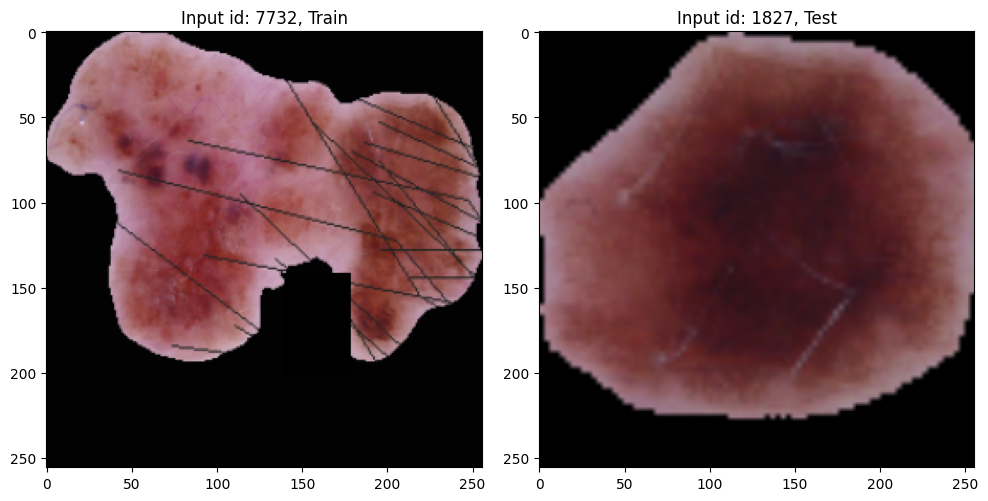

In [189]:
# Reload the dataset module using importlib
import importlib
importlib.reload(plots)

index_train = random.randint(0, len(lesion_dataset_train) - 1)
index_test = random.randint(0, len(lesion_dataset_test) - 1)

# Plot the data using the plot_data function from the plot module
plots.plot_data_PART2(lesion_dataset_train, lesion_dataset_test, index_train, index_test)

## 2. Classifier Model Configuration and Initialization

In this section, the chosen model architecture with the option to customize the dropout rate.

The script proceeds to initialize the specified model based on the chosen architecture (`MODEL`). Depending on the selected model, including options like 'random,' 'constant', or various ResNet configurations, the corresponding model instance is created and moved to the specified computing device.

`DROPOUT` can be used to introduce dropout using `nn.Dropout(p=DROPOUT)` at the model level.

In [177]:
# Reload the model module using importlib
import importlib
importlib.reload(models)

# Define the chosen model and set the filter numbers
MODEL = 'resnet50' # Change according to the model you want to train
DROPOUT = 0.5

# Choose and initialize the specified model based on the selected architecture
if MODEL == 'random':
    model = models.RandomGuessModel(task='classification').to(device)
elif MODEL == 'constant':
    model = models.ConstantModel(task='classification').to(device)
elif 'resnet18' in MODEL:
    model = models.ResNet18(p_dropout=DROPOUT).to(device)
elif 'resnet34' in MODEL:
    model = models.ResNet34(p_dropout=DROPOUT).to(device)
elif 'resnet50' in MODEL:
    model = models.ResNet50(p_dropout=DROPOUT).to(device)
elif 'resnet101' in MODEL:
    model = models.ResNet101(p_dropout=DROPOUT).to(device)
else:
    raise ValueError('Please choose one of the following models: random, constant, resnet18, resnet34, resnet50, resnet101 or resnet152.')

## 3. Model Training

In this script users can specify whether to load a pre-trained model (`LOAD`) and set the model name accordingly.

The Trainer is then initialized with the specified model and device, and based on the `LOAD` condition, either a new model is trained or a pre-trained model is loaded.

- If `LOAD` is set to `False`, the script defines parameters for training, such as the number of epochs (`EPOCHS`), learning rate (`LEARNING_RATE`), weight decay (`WEIGHT_DECAY`), and gradient clipping (`CLIP_GRADIENT`). The model is then trained for the specified number of epochs unless it's the 'random' or 'constant' model. Training and testing losses are recorded.

- If `LOAD` is set to `True`, a pre-trained model with the specified name (`MODEL_NAME`) is loaded using the `trainer.load_model` function.

In either case, informative messages are printed, indicating the completion of the training process or the successful loading of a pre-trained model.


In [178]:
# Reload the training module using importlib
import importlib
importlib.reload(training)

# Specify whether or not to load the pre-trained model
LOAD = False

# Set the model name
MODEL_NAME = f'{MODEL}.pt'

# Initialize the Trainer with the specified model and device
trainer = training.Trainer(model, device, task='classification')

if LOAD == False:
    # Set the number of training epochs
    EPOCHS = 40
    LEARNING_RATE = 5e-5
    WEIGHT_DECAY = 0.
    CLIP_GRADIENT = False

    # Train the model if it's not the random model
    if MODEL != 'random' and MODEL != 'constant':
      # Train the model for the specified number of epochs
      losses_train, losses_test = trainer.train(EPOCHS, trainloader, testloader=testloader, model_name=MODEL_NAME, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY, clip_gradient=CLIP_GRADIENT)

    # Display a message indicating the completion of the training process
    print(f'Training finished!')

else:
    # Load a pre-trained model
    trainer.load_model(MODEL_NAME)
    print(f'Pre-trained model {MODEL_NAME} loaded successfuly.')

Starting Training Process
Model saved at resnet50.pt
Epoch: 001, Train Loss: 0.0157854, Test Loss: 0.0148396, Time: 316.357 sec/epch
Epoch: 002, Train Loss: 0.0133719, Test Loss: 0.0117747, Time: 308.184 sec/epch
Epoch: 003, Train Loss: 0.0126384, Test Loss: 0.0115080, Time: 309.798 sec/epch
Epoch: 004, Train Loss: 0.0120724, Test Loss: 0.0109297, Time: 305.623 sec/epch
Epoch: 005, Train Loss: 0.0110115, Test Loss: 0.0080441, Time: 328.645 sec/epch
Model saved at resnet50.pt
Epoch: 006, Train Loss: 0.0102293, Test Loss: 0.0064319, Time: 305.983 sec/epch
Epoch: 007, Train Loss: 0.0093071, Test Loss: 0.0057901, Time: 307.342 sec/epch
Epoch: 008, Train Loss: 0.0091680, Test Loss: 0.0056623, Time: 303.544 sec/epch
Epoch: 009, Train Loss: 0.0083250, Test Loss: 0.0064028, Time: 305.750 sec/epch
Epoch: 010, Train Loss: 0.0078379, Test Loss: 0.0071585, Time: 306.224 sec/epch
Model saved at resnet50.pt
Epoch: 011, Train Loss: 0.0077610, Test Loss: 0.0077715, Time: 307.212 sec/epch
Epoch: 012, T

### Loss Visualization

This section checks if the selected model is not a benchmark model (neither 'random' nor 'constant'). 

- If the model is not a benchmark and training is not based on a pre-trained model (`LOAD == False`), the script plots the training and testing loss curves using the `plot_loss` function from the `plots` module.

- For benchmark models ('random' or 'constant') or pre-trained models, a message is printed indicating that loss plots are not available.

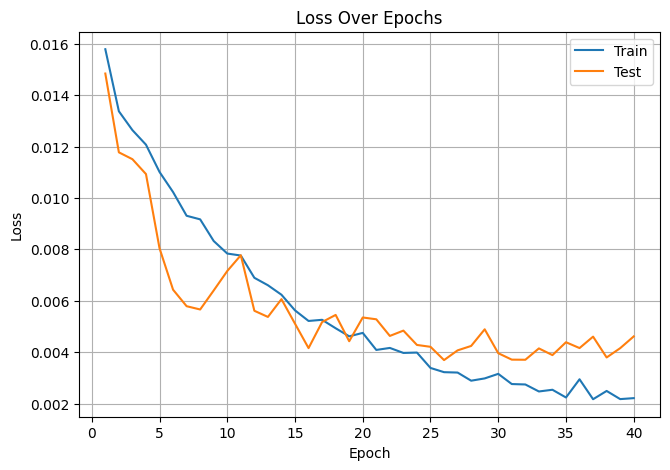

In [179]:
# Reload the plot module using importlib
import importlib
importlib.reload(plots)

# Check if the model is not a benchmark model (neither random nor constant)
if MODEL != 'random' and MODEL != 'constant':
  if LOAD == False:
    # Plot the training and testing loss curves using the plot_loss_unet function
    plots.plot_loss(losses_train, losses_test, save_path=None)
  else:
    # Print a message indicating that loss plots are not available for pre-loaded models
    print('Loss plot not available for pre-loaded models (please see the associated report).')
else:
  # Print a message indicating that loss plots are not available for benchmark models
  print('Loss plot not available for benchmark models.')

## 4. Model Evaluation and Performance Scores

This script checks whether the selected model is not a benchmark model (neither 'random' nor 'constant').

- If the model is not a benchmark, the script proceeds to load the state dictionary from the saved model. Depending on the availability of a GPU, the model is loaded directly if a GPU is present; otherwise, it is loaded onto the CPU using `map_location`.

- Subsequently, the model's performance is evaluated, and scores are obtained using the `get_scores_CLASS` function from the `utils` module. The evaluation involves comparing model predictions on the train and test dataset (`lesion_dataset_train` and `lesion_dataset_test`) against the ground truth labels. The specified threshold (`THRESHOLD`) is used to classify predictions.

In [180]:
# Reload the utils module using importlib
import importlib
importlib.reload(utils)

THRESHOLD = 0.5

# Check if the model is not a benchmark model (neither random nor constant)
if MODEL != 'random' and MODEL != 'constant':
  # Load the state dictionary from the saved model, use map_location to load on the CPU
  model = torch.load(MODEL_NAME, map_location=torch.device('cpu'))

# Evaluate the model's performance and obtain scores using the get_scores function
utils.get_scores_CLASS(trainer, lesion_dataset_test, dataset_train=None, threshold=THRESHOLD) # Set 'dataset_train = lesion_dataset_train' to get the training metrics

Number of positive pred. TEST: 235

Metric                         Test           
Accuracy                       0.9491         
Specificity                    0.9648         
Sensitivity                    0.8152         
F1 Score                       0.7713         


*---Please be aware that the following section has been implemented successfully but has not undergone thorough testing. Therefore, you may choose to disregard this section entirely.---*

# PART 3: Metadata Integration
In this section, the aim is to extend the classification efforts by incorporating additional available patient metadata (age, lesion location, and sex). The model performance evaluation will involve key metrics such as accuracy, specificity, sensitivity, precision, and F1-score.

## 1. Dataset and Dataloader

The following dataset is compatible with this part of the project:

- [ISIC2019](https://challenge.isic-archive.com/data/#2019):  Compiled dataset consisting of 25'331 dermatoscopic images in JPEG format with corresponding patient metadata entries (age, lesion location and sex) along with entries indicating gold standard malignant status (skin leasion classification in 9 different categories).

Please note that for the purpose of this work, only binary classification was investigated (non-melanoma vs melanoma). Therefore, the analysis and training processes focused exclusively on the melanoma category of each dataset, considering the gold standard malignant status provided in the entries.

### Dataset Preparation and Formatting

In this code excerpt, the script defines the path for the dataset (`DATASET_PATH`) and specifies the dataset to be used (`DATASET_USED`). If needed, the code includes an uncommented line to unzip the dataset using the `utils.unzip_data` function.

Subsequently, the complete path to the dataset (`DATA_PATH`) is created, and another uncommented line is provided to format the dataset using the `utils.format_dataset_PART2` function. This step ensures that the dataset is prepared and formatted appropriately for subsequent machine learning tasks.

In [ ]:
# Reload the model module using importlib
import importlib
importlib.reload(utils)

# Define the path for the dataset and specify the dataset to be used
DATASET_PATH = 'data' # Modify to match your folder structure. For Colab: '/content/data'.
DATASET_USED = 'ISIC2019'
SPLIT_RATIO = 0.2

# Create the complete path to the dataset
DATA_PATH = os.path.join(DATASET_PATH, DATASET_USED)

# Delete data foders if they already exist
utils.delete_folder(DATA_PATH)

# Unzip the dataset
utils.unzip_data(DATASET_PATH, DATASET_USED)

# Split in train and test dataset according to the SPLIT_RATIO
utils.split_folders(DATA_PATH, p_test=SPLIT_RATIO, type='classification', metadata=True, seed=11) 

# Format the dataset for processing
utils.format_dataset(DATA_PATH, task='classification', test_folder=True, benchmark=False)

### Defining the Segmentation Model

This following code snippet, defines a pre-trained segmentation model, and initializes a trainer for that model. It allows you to choose between different segmentation models (simple_cnn, unet, or unet++) and set specific filter compositions. The code then instantiates the chosen model, and loads a pre-trained segmentation model for further use (prost-proceesing is automatically applied to segmentation predictions). Adjust the segmentation model choice and parameters as needed.

In [ ]:
# Reload the model module using importlib
import importlib
importlib.reload(models)
importlib.reload(training)

# Define the chosen model and set the filter numbers
SEG_MODEL = 'unet++' # Change according to the model you want to use as segmentor
SEG_MODEL_NAME = f'{SEG_MODEL}.pt'
filter_num = [8, 16, 32, 64, 128] # Set filter composition

# Choose and initialize the specified model based on the selected architecture
if SEG_MODEL == 'simple_cnn':
    model_seg = models.SimpleCNN().to(device)
elif SEG_MODEL == 'unet':
    model_seg = models.UNet(filter_num).to(device)
elif SEG_MODEL == 'unet++':
    model_seg = models.UNetPlusPlus(filter_num).to(device)
else:
    raise ValueError('Please choose one of the following models: simple_cnn, unet, or unet++')

# Initialize the segmentation trainner
trainer_seg = training.Trainer(model_seg, device)

# Load the pre-trained segmentation model
trainer_seg.load_model(SEG_MODEL_NAME)

### Data Splitting

In this code snippet, the batch size for data loading is set, and a `LesionDataset` is created for a classification test task. The dataset is then randomly split into training and testing sets with an given ratio. Finally, the sizes of the original, training, and test datasets are displayed for quick reference.

`metadat=True`in the `dataset.LesionDataset` insure the metadata integration.

In [ ]:
# Reload the dataset module using importlib
import importlib
importlib.reload(dataset)

# Create training and testing datasets using the LesionDataset class
lesion_dataset_train = dataset.LesionDataset(DATA_PATH, TYPE='train', task='classification', trainer_seg=trainer_seg, metadata=True)
lesion_dataset_test = dataset.LesionDataset(DATA_PATH, TYPE='test', task='classification', trainer_seg=trainer_seg, metadata=True)

# Display the sizes of the original, training, and test datasets
print("+" + "-" * 30 + "+")
print(f"| Original dataset            | {len(lesion_dataset_train) + len(lesion_dataset_test)}{' ' * (20 - len(str(len(lesion_dataset_train) + len(lesion_dataset_test))))}")
print(f"| Training dataset            | {len(lesion_dataset_train)}{' ' * (20 - len(str(len(lesion_dataset_train))))}")
print(f"| Test dataset                | {len(lesion_dataset_test)}{' ' * (20 - len(str(len(lesion_dataset_test))))}")

### Resampling Strategy and DataLoader Configuration

This code segment defines and implements a resampling strategy for dataset balancing. Depending on the specified resampling strategy, the code creates DataLoaders either with or without the use of WeightedRandomSampler.

- When `RESAMPLING` is set to `None`, DataLoaders are created without resampling, utilizing a regular shuffle strategy.
- In the case of `RESAMPLING` being set to 'upsampling', a WeightedRandomSampler is employed to balance the dataset. The weights for each class are calculated, and a WeightedRandomSampler is created using these weights for the training set. A regular DataLoader is used for the test set.
- `RESAMPLING_RATIO` can be used to manipulate the upsampling ratio (`RESAMPLING_RATIO = 1` corresponds to a 1:1 sampling).
- The code concludes by displaying the label ratio in the training set and printing the label distribution in the first 5 batches of the training set.

When selected, the upsampling strategy is exclusively applied to the training set to avoid any potential bias introduced during testing. The test set remains unchanged, ensuring the evaluation reflects the original distribution of classes. 

In [ ]:
# Define the resampling strategy ('upsampling' or None) and the resampling ratio
RESAMPLING = 'upsampling'
RESAMPLING_RATIO = 1
BATCH_SIZE = 32 # Set the batch size for data loading

if RESAMPLING is None:
    # No resampling - create DataLoader without WeightedRandomSampler
    trainloader = torch.utils.data.DataLoader(lesion_dataset_train, batch_size=BATCH_SIZE, shuffle=True)
    testloader = torch.utils.data.DataLoader(lesion_dataset_test, batch_size=BATCH_SIZE, shuffle=True)
    
elif RESAMPLING == 'upsampling':
    # Upsampling strategy to balance the dataset using WeightedRandomSampler
    # Get labels from the training dataset
    labels = utils.get_labels(lesion_dataset_train)

    # Count the number of samples in each class
    class_sample_count = np.array([len(np.where(labels == t)[0]) for t in np.unique(labels)])

    # Calculate weights for each class to balance the dataset
    weight = 1. / class_sample_count
    weight[-1] = weight[-1] * RESAMPLING_RATIO

    # Compute sample weights for each instance in the training set
    samples_weight = np.array([weight[t] for t in labels])
    samples_weight = torch.from_numpy(samples_weight)

    # Create a WeightedRandomSampler using the calculated weights
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

    # Create DataLoader with WeightedRandomSampler for training set and regular DataLoader for test set
    trainloader = torch.utils.data.DataLoader(lesion_dataset_train, batch_size=BATCH_SIZE, sampler=sampler)
    testloader = torch.utils.data.DataLoader(lesion_dataset_test, batch_size=BATCH_SIZE, shuffle=True)

# Display the ratio of labels in the training set
total_labels = len(labels)
ratio_1 = len(np.where(labels == 1)[0])
ratio_0 = len(np.where(labels == 0)[0])

print(f"Training label ratio '1'/'0': {ratio_1}/{ratio_0}")

# Print the label distribution in the first 5 batches of the training set
print("Batch Index   | Ratio '1'   | Ratio '0'")
print("---------------------------------------")
for i, data in enumerate(itertools.islice(trainloader, 5)):
    gt = data['label'].to(device).float()
    ratio_1_batch = (gt == 1).sum().item()
    ratio_0_batch = (gt == 0).sum().item()
    print(f"Batch {i+1:<2}        | {ratio_1_batch:<11} | {ratio_0_batch:<11}")

### Data Transformation

The following transformations are applied to the training set:
- `TF.hflip()`: Random horizontal flipping with a probability of 50%
- `TF.vflip()`: Random vertical flipping with a probability of 50%
- `T.RandomRotation()`: Random rotation up to 45 degrees with a probability of 50%
- `T.RandomAffine()`: Random zoom with a maximum of 120% with a probability of 50%
- `roi(seg_model)`: That extracts the region of interest from the original image using the segmentation model (or the groundtruth if `BENCHMARK_SEG == True`)
- `add_hair()`: Add artificial hair with a probability of 50%
- `transforms.ColorJitter()`: Adds controlled variability to the images by randomly adjusting their brightness, contrast, saturation, and hue with a probability of 50%
- `T.RandomErasing()`: Applies random erasing to input images with a probability of 25%

Note that proper resizing (224x224) is also performed to match the different model needs.

The following code snippet generates random indices for both the training and test datasets. Subsequently, it employs the `plot_data_PART2` function from the `plots` module to visualize data corresponding to the randomly selected indices.

In [ ]:
# Reload the dataset module using importlib
import importlib
importlib.reload(plots)

index_train = random.randint(0, len(lesion_dataset_train) - 1)
index_test = random.randint(0, len(lesion_dataset_test) - 1)

# Plot the data using the plot_data function from the plot module
plots.plot_data_PART2(lesion_dataset_train, lesion_dataset_test, index_train, index_test)

## 2. Classifier Model Configuration and Initialization

In this section, the chosen model architecture with the option to customize the dropout rate.

The script proceeds to initialize the specified model based on the chosen architecture (`MODEL`). Depending on the selected model, including options like 'random,' 'constant', or various ResNet configurations, the corresponding model instance is created and moved to the specified computing device.

`metadata` is set to `True` for the integration of metadata in the models.

It's crucial to note that users can seamlessly tailor the model selection to their specific requirements by adjusting the `MODEL` variable.

In [ ]:
# Reload the model module using importlib
import importlib
importlib.reload(models)

# Define the chosen model and set the filter numbers
MODEL = 'resnet50_meta' # Change according to the model you want to train
DROPOUT = 0.5

# Choose and initialize the specified model based on the selected architecture
if MODEL == 'random':
    model = models.RandomGuessModel(task='classification').to(device)
elif MODEL == 'constant':
    model = models.ConstantModel(task='classification').to(device)
elif 'resnet18_meta' in MODEL:
    model = models.ResNet18(metadata=True, num_metadata_features=3, p_dropout=DROPOUT).to(device)
elif 'resnet34_meta' in MODEL:
    model = models.ResNet34(metadata=True, num_metadata_features=3, p_dropout=DROPOUT).to(device)
elif 'resnet50_meta' in MODEL:
    model = models.ResNet50(metadata=True, num_metadata_features=3, p_dropout=DROPOUT).to(device)
elif 'resnet101_meta' in MODEL:
    model = models.ResNet101(metadata=True, num_metadata_features=3, p_dropout=DROPOUT).to(device)
else:
    raise ValueError('Please choose one of the following models: random, constant, resnet18_meta, resnet34_meta, resnet50_meta or resnet101_meta.')

## 3. Model Training

In this script users can specify whether to load a pre-trained model (`LOAD`) and set the model name accordingly.

The Trainer is then initialized with the specified model and device, and based on the `LOAD` condition, either a new model is trained or a pre-trained model is loaded.

- If `LOAD` is set to `False`, the script defines parameters for training, such as the number of epochs (`EPOCHS`), learning rate (`LEARNING_RATE`), weight decay (`WEIGHT_DECAY`), and gradient clipping (`CLIP_GRADIENT`). The model is then trained for the specified number of epochs unless it's the 'random' or 'constant' model. Training and testing losses are recorded.

- If `LOAD` is set to `True`, a pre-trained model with the specified name (`MODEL_NAME`) is loaded using the `trainer.load_model` function.

In either case, informative messages are printed, indicating the completion of the training process or the successful loading of a pre-trained model.


In [ ]:
# Reload the training module using importlib
import importlib
importlib.reload(training)

# Specify whether or not to load the pre-trained model
LOAD = False

# Set the model name
MODEL_NAME = f'{MODEL}.pt'

# Initialize the Trainer with the specified model and device
trainer = training.Trainer(model, device, task='classification')

if LOAD == False:
    # Set the number of training epochs
    EPOCHS = 40
    LEARNING_RATE = 5e-5
    WEIGHT_DECAY = 0
    CLIP_GRADIENT = False

    # Train the model if it's not the random model
    if MODEL != 'random' and MODEL != 'constant':
      # Train the model for the specified number of epochs
      losses_train, losses_test = trainer.train(EPOCHS, trainloader, testloader, metadata=True, model_name=MODEL_NAME, learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY, clip_gradient=CLIP_GRADIENT)

    # Display a message indicating the completion of the training process
    print(f'Training finished!')

else:
    # Load a pre-trained model
    trainer.load_model(MODEL_NAME)
    print(f'Pre-trained model {MODEL_NAME} loaded successfuly.')

### Loss Visualization

This section checks if the selected model is not a benchmark model (neither 'random' nor 'constant'). 

- If the model is not a benchmark and training is not based on a pre-trained model (`LOAD == False`), the script plots the training and testing loss curves using the `plot_loss` function from the `plots` module.

- For benchmark models ('random' or 'constant') or pre-trained models, a message is printed indicating that loss plots are not available.

This visualization aids in assessing the training progress and performance of the model over epochs.


In [ ]:
# Reload the plot module using importlib
import importlib
importlib.reload(plots)

# Check if the model is not a benchmark model (neither random nor constant)
if MODEL != 'random' and MODEL != 'constant':
  if LOAD == False:
    # Plot the training and testing loss curves using the plot_loss_unet function
    plots.plot_loss(losses_train, losses_test, save_path=None)
  else:
    # If a pre-trained model is loaded, recover train and test epoch losses
    losses_train = []
    losses_test  = []

    # Plot the training and testing loss curves using the plot_loss_unet function
    plots.plot_loss(losses_train, losses_test, save_path=None)
else:
  # Print a message indicating that loss plots are not available for benchmark models
  print('Loss plot not available for benchmark models.')

## 4. Model Evaluation and Performance Scores

This script checks whether the selected model is not a benchmark model (neither 'random' nor 'constant').

- If the model is not a benchmark, the script proceeds to load the state dictionary from the saved model. Depending on the availability of a GPU, the model is loaded directly if a GPU is present; otherwise, it is loaded onto the CPU using `map_location`.

- Subsequently, the model's performance is evaluated, and scores are obtained using the `get_scores_CLASS` function from the `utils` module. The evaluation involves comparing model predictions on the test dataset (`lesion_dataset_test`) against the ground truth labels. The specified threshold (`THRESHOLD`) is used to classify predictions.

This process provides valuable insights into the model's classification performance and aids in assessing its effectiveness on unseen data.


In [ ]:
# Reload the utils module using importlib
import importlib
importlib.reload(utils)

THRESHOLD = 0.5

# Check if the model is not a benchmark model (neither random nor constant)
if MODEL != 'random' and MODEL != 'constant':
  # Load the state dictionary from the saved model, use map_location to load on the CPU
  model = torch.load(MODEL_NAME, map_location=torch.device('cpu'))

# Evaluate the model's performance and obtain scores using the get_scores function
utils.get_scores_CLASS(trainer, lesion_dataset_test, dataset_train=None, threshold=THRESHOLD, metadata=True) # Set 'dataset_train = lesion_dataset_train' to get the training metrics

# Dataset Citation

(comply with the attribution requirements of the CC-BY-NC license)

[1] Gutman, David; Codella, Noel C. F.; Celebi, Emre; Helba, Brian; Marchetti, Michael; Mishra, Nabin; Halpern, Allan. "Skin Lesion Analysis toward Melanoma Detection: A Challenge at the International Symposium on Biomedical Imaging (ISBI) 2016, hosted by the International Skin Imaging Collaboration (ISIC)". eprint arXiv:1605.01397. 2016.

[2] Codella N, Gutman D, Celebi ME, Helba B, Marchetti MA, Dusza S, Kalloo A, Liopyris K, Mishra N, Kittler H, Halpern A. "Skin Lesion Analysis Toward Melanoma Detection: A Challenge at the 2017 International Symposium on Biomedical Imaging (ISBI), Hosted by the International Skin Imaging Collaboration (ISIC)". arXiv: 1710.05006 [cs.CV]

[3] Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 doi:10.1038/sdata.2018.161 (2018).

[2] Noel C. F. Codella, David Gutman, M. Emre Celebi, Brian Helba, Michael A. Marchetti, Stephen W. Dusza, Aadi Kalloo, Konstantinos Liopyris, Nabin Mishra, Harald Kittler, Allan Halpern: "Skin Lesion Analysis Toward Melanoma Detection: A Challenge at the 2017 International Symposium on Biomedical Imaging (ISBI), Hosted by the International Skin Imaging Collaboration (ISIC)", 2017; arXiv:1710.05006.

[3] Marc Combalia, Noel C. F. Codella, Veronica Rotemberg, Brian Helba, Veronica Vilaplana, Ofer Reiter, Allan C. Halpern, Susana Puig, Josep Malvehy: "BCN20000: Dermoscopic Lesions in the Wild", 2019; arXiv:1908.02288.